## Q3: Online Retail - Time Series Analysis




#### 1. Import libraries and data

In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pd.options.display.float_format = '{:,.2f}'.format
# plt.rcParams['figure.figsize'] = 12, 6
sns.set_style('whitegrid')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("D:/Downloads/OnlineRetail.csv", encoding = "ISO-8859-1")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,"17,850.00",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,"17,850.00",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,"17,850.00",United Kingdom


#### 2. Data Preprocessing

##### 2.1 Basic Operations

In [3]:
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    536641 non-null  object 
 1   StockCode    536641 non-null  object 
 2   Description  535187 non-null  object 
 3   Quantity     536641 non-null  int64  
 4   InvoiceDate  536641 non-null  object 
 5   UnitPrice    536641 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      536641 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.8+ MB


In [4]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401604 entries, 0 to 401603
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 24.5+ MB


In [5]:
# Create a Sales column
data['Sales'] = data['Quantity'] * data['UnitPrice']

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401604 entries, 0 to 401603
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      401604 non-null  object 
 8   Sales        401604 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 27.6+ MB


In [7]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Sales'],
      dtype='object')

In [8]:
data.drop(columns=['InvoiceNo', 'StockCode', 'Description', 'Quantity',
                   'UnitPrice', 'CustomerID', 'Country'], axis=1, inplace=True)

In [9]:
data = data.rename({'InvoiceDate': 'Dates'}, axis=1)
data.head()

,Dates,Sales
0,12/1/2010 8:26,15.30
1,12/1/2010 8:26,20.34
2,12/1/2010 8:26,22.00
3,12/1/2010 8:26,20.34
4,12/1/2010 8:26,20.34


In [10]:
df = data.copy()

In [11]:
df['Dates'] = pd.to_datetime(df['Dates'], 
                            #  format='%d-%m-%Y', 
                            format='mixed', )

# Drop time elements
df['Dates'] = df['Dates'].dt.date
df.head()

,Dates,Sales
0,2010-12-01,15.30
1,2010-12-01,20.34
2,2010-12-01,22.00
3,2010-12-01,20.34
4,2010-12-01,20.34


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401604 entries, 0 to 401603
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Dates   401604 non-null  object 
 1   Sales   401604 non-null  float64
dtypes: float64(1), object(1)
memory usage: 6.1+ MB


##### 2.2 EDA - I

In [13]:
df_daily = df.groupby('Dates')['Sales'].sum().reset_index()
df_daily.set_index('Dates', inplace=True)
df_daily.head(40)

,Sales
Dates,
2010-12-01,"45,867.26"
2010-12-02,"45,656.47"
2010-12-03,"22,553.38"
2010-12-05,"30,970.28"
2010-12-06,"30,258.77"
2010-12-07,"53,061.64"
2010-12-08,"37,894.06"
2010-12-09,"37,139.86"
2010-12-10,"31,903.45"


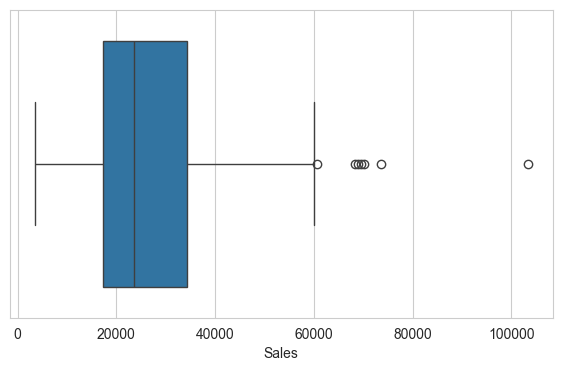

In [14]:
plt.figure(figsize=(7, 4))
sns.boxplot(data=df_daily, x='Sales', whis=1.5)
plt.show()

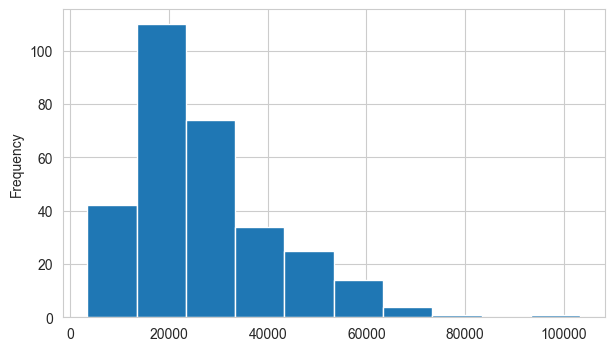

In [15]:
plt.figure(figsize=(7, 4))

df_daily['Sales'].plot.hist()
plt.show()

In [16]:
### Removing the outliers 

# Calculate the Interquartile Range (IQR)
Q1 = df_daily['Sales'].quantile(0.25)
Q3 = df_daily['Sales'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower & upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers based on IQR
df_daily = df_daily[ (df_daily['Sales'] >= lower_bound) & 
                     (df_daily['Sales'] <= upper_bound)]
df_daily.describe()

,Sales
count,298.00
mean,"26,054.01"
std,"12,824.43"
min,"3,439.67"
25%,"17,000.16"
50%,"23,120.55"
75%,"32,799.00"
max,"60,111.38"


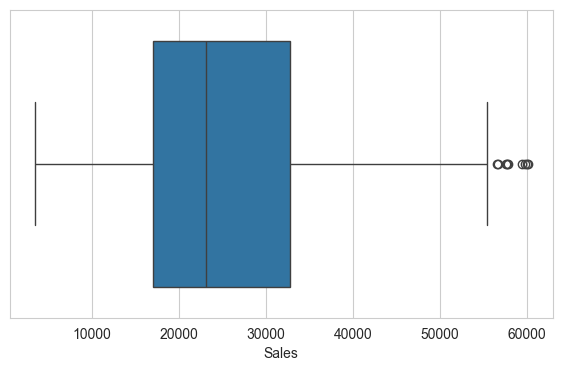

In [17]:
plt.figure(figsize=(7, 4))

sns.boxplot(data=df_daily, x='Sales', whis=1.5)
plt.show()

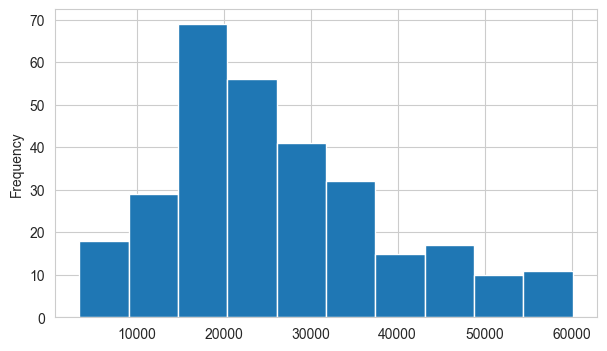

In [18]:
plt.figure(figsize=(7, 4))

df_daily['Sales'].plot.hist()
plt.show()

##### 2.3 Checking for missing days of the week

In [19]:
# Generate a complete date range
complete_date_range = pd.date_range(start=df_daily.index.min(), 
                                    end=df_daily.index.max(), freq='D')

missing_dates = complete_date_range.difference(df_daily.index)

# Display missing dates
print("Missing Dates:")
print(missing_dates)

Missing Dates:
DatetimeIndex(['2010-12-04', '2010-12-11', '2010-12-18', '2010-12-24',
               '2010-12-25', '2010-12-26', '2010-12-27', '2010-12-28',
               '2010-12-29', '2010-12-30', '2010-12-31', '2011-01-01',
               '2011-01-02', '2011-01-03', '2011-01-08', '2011-01-15',
               '2011-01-22', '2011-01-29', '2011-02-05', '2011-02-12',
               '2011-02-19', '2011-02-26', '2011-03-05', '2011-03-12',
               '2011-03-19', '2011-03-26', '2011-04-02', '2011-04-09',
               '2011-04-16', '2011-04-22', '2011-04-23', '2011-04-24',
               '2011-04-25', '2011-04-29', '2011-04-30', '2011-05-02',
               '2011-05-07', '2011-05-14', '2011-05-21', '2011-05-28',
               '2011-05-30', '2011-06-04', '2011-06-11', '2011-06-18',
               '2011-06-25', '2011-07-02', '2011-07-09', '2011-07-16',
               '2011-07-23', '2011-07-30', '2011-08-06', '2011-08-13',
               '2011-08-20', '2011-08-27', '2011-08-29', '2011

In [20]:
import datetime
import calendar
import holidays
from datetime import date, datetime

In [21]:
my_day = datetime.date(pd.to_datetime('2010-12-04')).weekday()
print(my_day)

my_date = pd.to_datetime('2010-12-04')
calendar.day_name[my_date.weekday()] 

5


'Saturday'

In [22]:
dt = datetime.date(pd.to_datetime('2010-12-04'))
print(dt.day, dt.strftime('%A'))

d = pd.Timestamp('2010-12-04')
print(d.dayofweek, d.day_name())

4 Saturday
5 Saturday


In [23]:
# Check for holidays in US
us_holidays = holidays.US()

# Print all the holidays in US in year 2011
for ptr in holidays.US(years = 2011).items():
    print(ptr[0], ptr[1])

2011-01-01 New Year's Day
2011-05-30 Memorial Day
2011-07-04 Independence Day
2011-09-05 Labor Day
2011-11-11 Veterans Day
2011-11-24 Thanksgiving
2011-12-25 Christmas Day
2011-12-26 Christmas Day (observed)
2011-01-17 Martin Luther King Jr. Day
2011-02-21 Washington's Birthday


In [24]:
missing_dates = pd.to_datetime(missing_dates)

# Filter out Saturdays from the missing dates
saturdays = missing_dates[missing_dates.day_of_week == 5]

# Display Saturdays
print("Saturdays in missing dates:")
print(saturdays)

Saturdays in missing dates:
DatetimeIndex(['2010-12-04', '2010-12-11', '2010-12-18', '2010-12-25',
               '2011-01-01', '2011-01-08', '2011-01-15', '2011-01-22',
               '2011-01-29', '2011-02-05', '2011-02-12', '2011-02-19',
               '2011-02-26', '2011-03-05', '2011-03-12', '2011-03-19',
               '2011-03-26', '2011-04-02', '2011-04-09', '2011-04-16',
               '2011-04-23', '2011-04-30', '2011-05-07', '2011-05-14',
               '2011-05-21', '2011-05-28', '2011-06-04', '2011-06-11',
               '2011-06-18', '2011-06-25', '2011-07-02', '2011-07-09',
               '2011-07-16', '2011-07-23', '2011-07-30', '2011-08-06',
               '2011-08-13', '2011-08-20', '2011-08-27', '2011-09-03',
               '2011-09-10', '2011-09-17', '2011-09-24', '2011-10-01',
               '2011-10-08', '2011-10-15', '2011-10-22', '2011-10-29',
               '2011-11-05', '2011-11-12', '2011-11-19', '2011-11-26',
               '2011-12-03'],
              dtype

In [25]:
# Reindex the DataFrame to include all dates
df_daily = df_daily.reindex(complete_date_range).reset_index(names=['Dates', 'Sales'])
df_daily.set_index('Dates', inplace=True)


df_daily.head(40)

,Sales
Dates,
2010-12-01,"45,867.26"
2010-12-02,"45,656.47"
2010-12-03,"22,553.38"
2010-12-04,NaN
2010-12-05,"30,970.28"
2010-12-06,"30,258.77"
2010-12-07,"53,061.64"
2010-12-08,"37,894.06"
2010-12-09,"37,139.86"


In [26]:
# Fill missing values for holidays with median values
df_daily['Sales'] = df_daily['Sales'].fillna(df_daily['Sales'].median())

# Fill Saturdays with 0
df_daily.loc[df_daily.index.dayofweek == 5, 'Sales'] = 0

df_daily.head(40)

,Sales
Dates,
2010-12-01,"45,867.26"
2010-12-02,"45,656.47"
2010-12-03,"22,553.38"
2010-12-04,0.00
2010-12-05,"30,970.28"
2010-12-06,"30,258.77"
2010-12-07,"53,061.64"
2010-12-08,"37,894.06"
2010-12-09,"37,139.86"


In [27]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374 entries, 2010-12-01 to 2011-12-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   374 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


In [28]:
df_daily.describe()

,Sales
count,374.00
mean,"22,181.47"
std,"14,591.18"
min,0.00
25%,"13,208.80"
50%,"22,078.31"
75%,"30,574.11"
max,"60,111.38"


##### 2.4 EDA - II

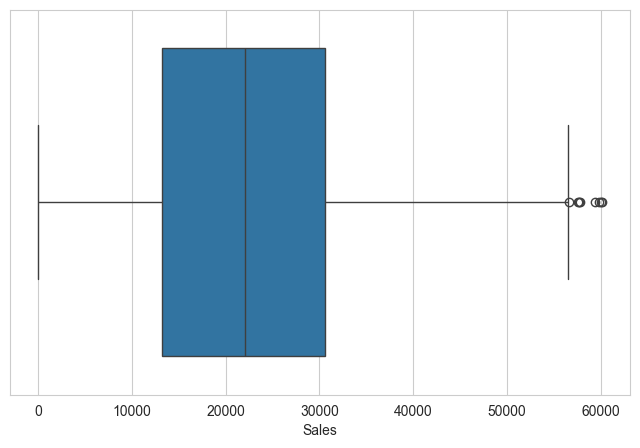

In [29]:
plt.figure(figsize=(8, 5))

sns.boxplot(data=df_daily, x='Sales', whis=1.5)
plt.show()

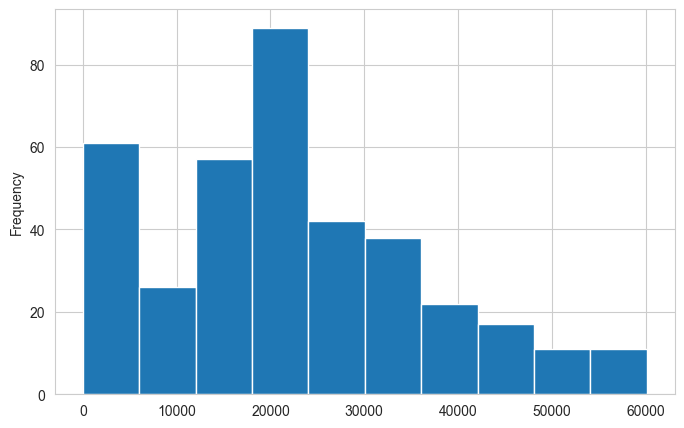

In [30]:
plt.figure(figsize=(8, 5))

df_daily['Sales'].plot.hist()
plt.show()

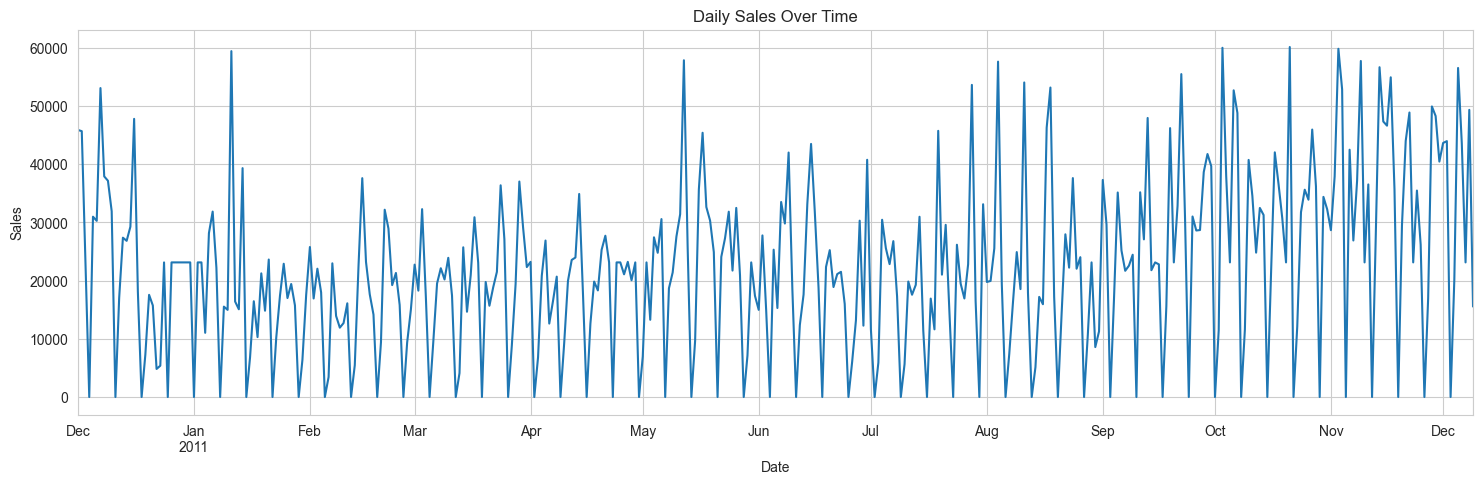

In [31]:
# Plot the data
plt.figure(figsize=(18, 5))

df_daily['Sales'].plot()

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Sales Over Time')
plt.show()

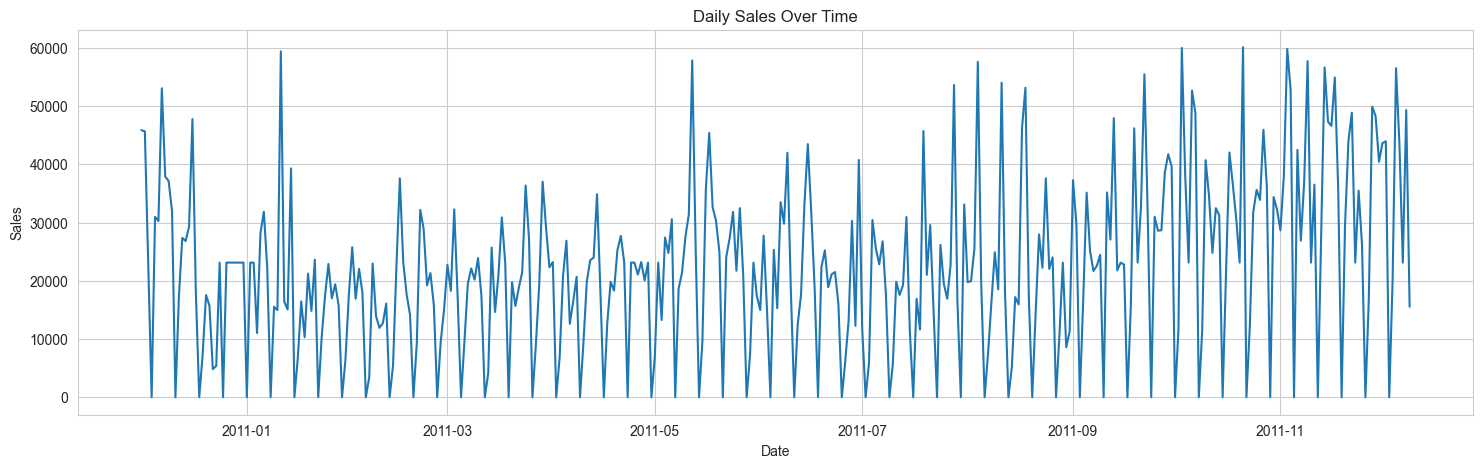

In [32]:
# Plot the data
plt.figure(figsize=(18, 5))

sns.lineplot(df_daily['Sales'])

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Sales Over Time')
plt.show()

#### 3. Seasonal Decomposition

Decompose the Time Series: Break down the series into trend, seasonality, and residuals.

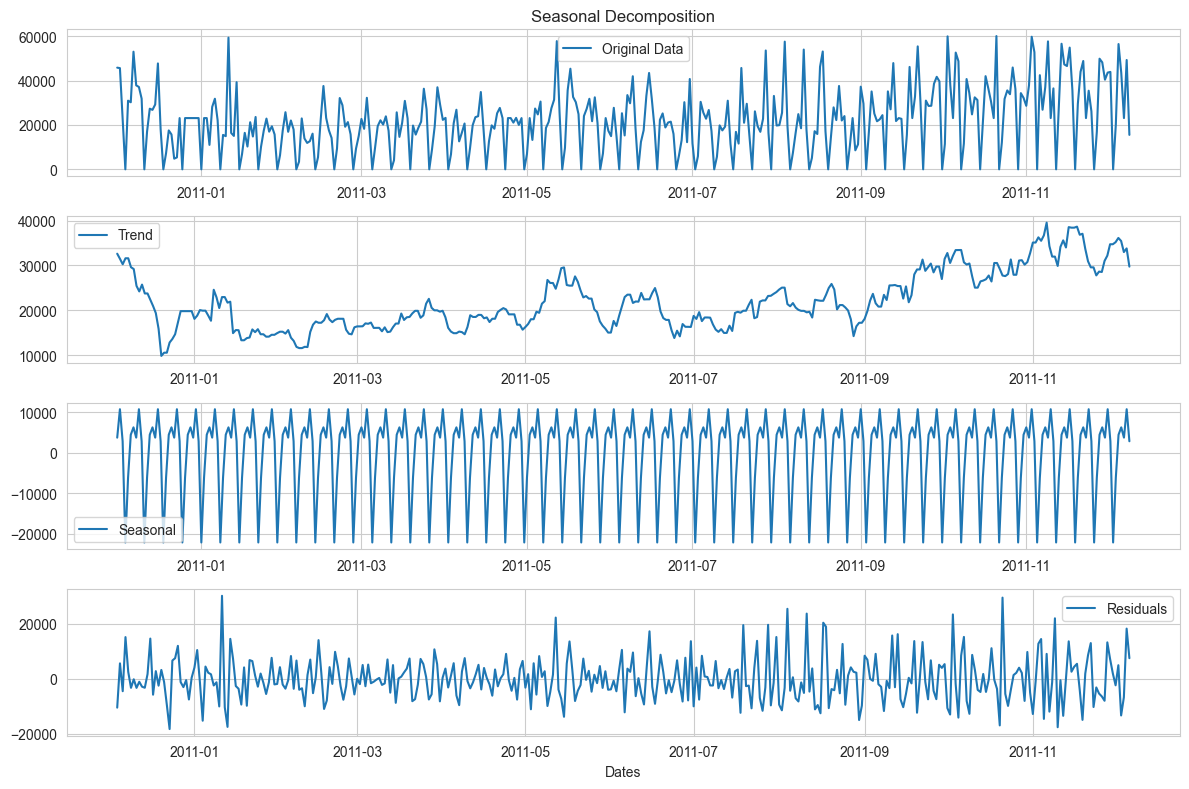

In [33]:
# Seasonal decomposition
result = seasonal_decompose(df_daily, model='additive', period=7) 

# Plot the original data, trend and residuals
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df_daily, label='Original Data')
plt.legend()
plt.title('Seasonal Decomposition')

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuals')
plt.legend()

plt.xlabel('Dates')
plt.tight_layout()
plt.show()

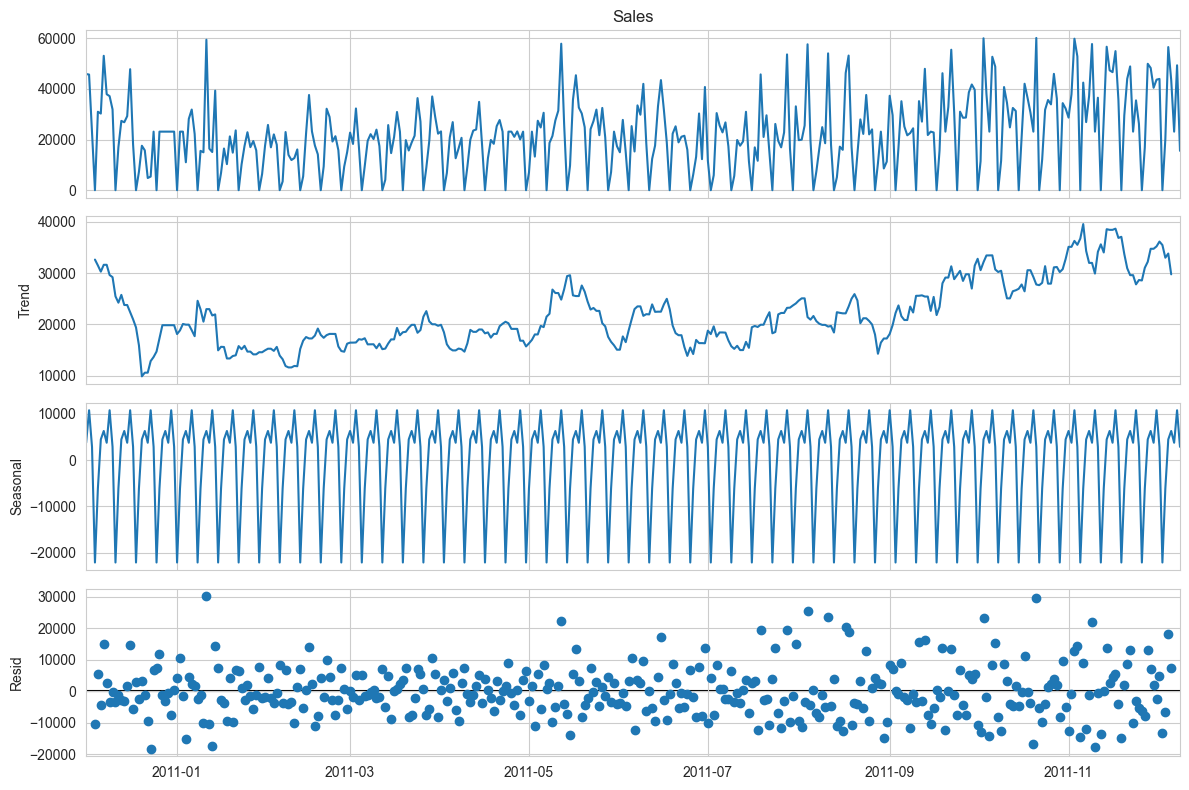

In [34]:
result_daily = seasonal_decompose(df_daily['Sales'], model='additive', period=7)

# plt.subplots(figsize=(15, 8))
plt.rcParams['figure.figsize'] = (12, 8)

result_daily.plot()
plt.show()

#### 4. Training & Testing Data

In [42]:
! pip install pmdarima

In [43]:
from pmdarima.arima import auto_arima

In [44]:
# train - test split
train_size = 342 # out of 373 days

train = df_daily[:train_size] 
test = df_daily[train_size:]

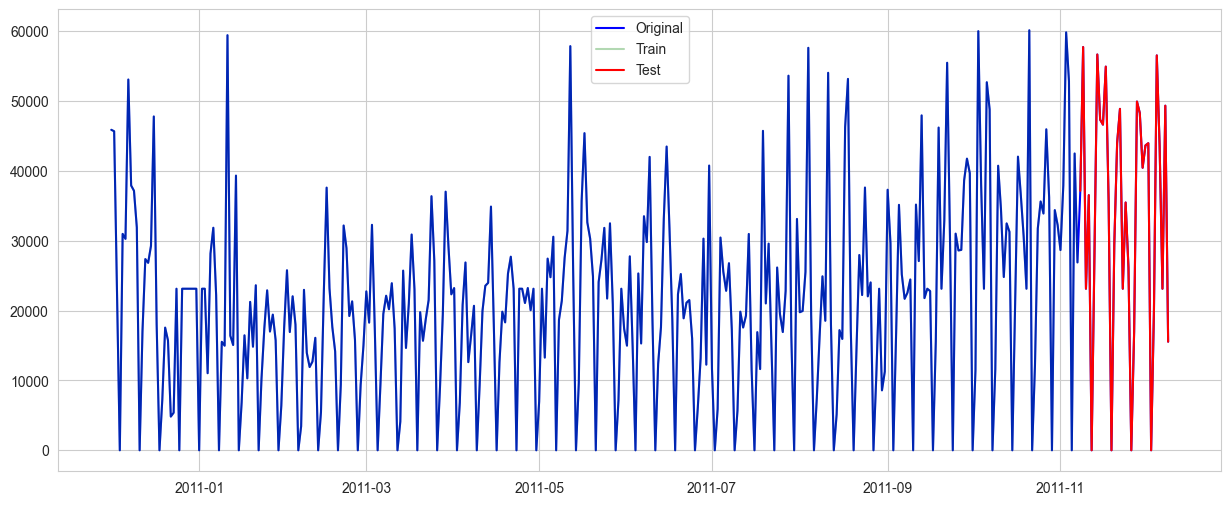

In [45]:
plt.figure(figsize=(15, 6))

plt.plot(df_daily, color='blue', label='Original')
plt.plot(train, color='green', label='Train', alpha=0.3)
plt.plot(test, color='red', label='Test')

plt.legend()
plt.show()

In [46]:
model = auto_arima(train, trace=True, error_action='ignore', 
                   suppress_warnings=True)
model.fit(train)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7417.930, Time=8.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7621.848, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7597.938, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7457.114, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7619.853, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7439.895, Time=0.88 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7441.458, Time=0.58 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7418.616, Time=0.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7398.639, Time=0.81 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7430.974, Time=0.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=7388.335, Time=0.68 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=7432.255, Time=0.27 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=7392.002, Time=0.85 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  342
Model:               SARIMAX(2, 1, 5)   Log Likelihood               -3663.136
Date:                Tue, 17 Dec 2024   AIC                           7342.272
Time:                        00:48:18   BIC                           7372.927
Sample:                    12-01-2010   HQIC                          7354.486
                         - 11-07-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2455      0.006    208.120      0.000       1.234       1.257
ar.L2         -0.9981      0.005   -218.648      0.000      -1.007      -0.989
ma.L1         -2.2042      0.080    -27.611      0.000      -2.361      -2.048
ma.L2          2.0427      0.191     10.693      0.000       1.668       2.417
ma.L3         -0.5349      0.246     -2.178      0.029      -1.016      -0.053
ma.L4         -0.4628      0.194     -2.384      0.017      -0.843      -0.082
ma.L5          0.2637      0.080      3.279      0.001       0.106       0.421
sigma2      1.685e+08   1.29e-09    1.3e+17      0.000    1.68e+08    1.68e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.19   Jarque-Bera (JB):                23.85
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                             0.59
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.44e+33. Standard errors may be unstable.
"""

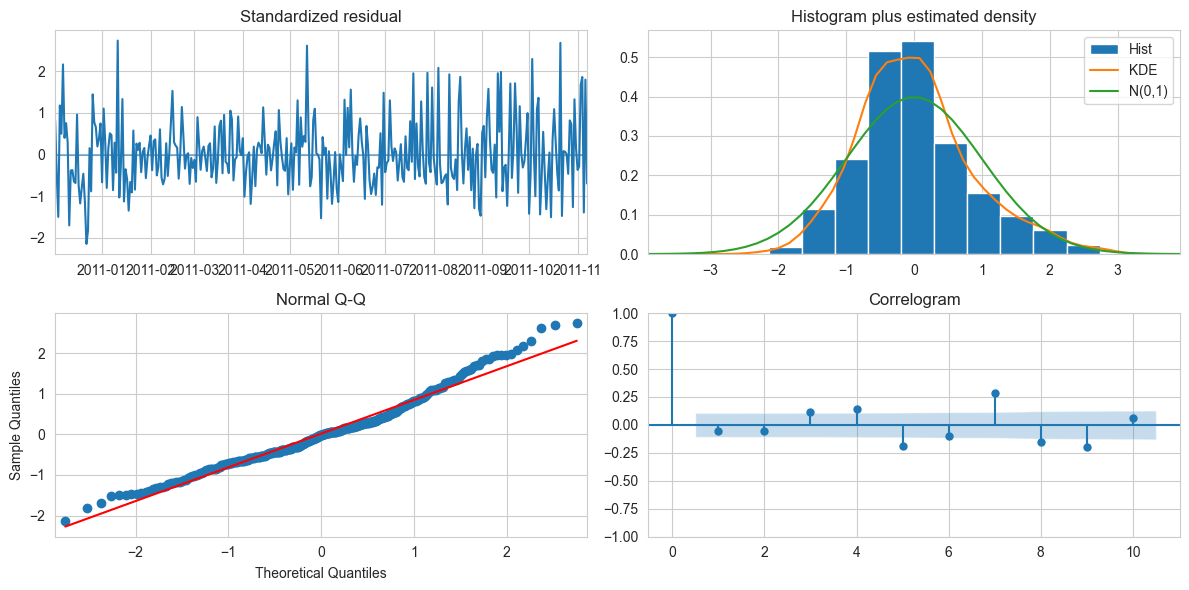

In [47]:
model.plot_diagnostics(figsize=(12, 6))
plt.tight_layout();

In [48]:
forecast = model.predict(n_periods=len(test))

forecast = pd.DataFrame(forecast, index=test.index, columns=['Forecast'])
forecast

,Forecast
Dates,
2011-11-08,"36,731.63"
2011-11-09,"48,454.43"
2011-11-10,"42,467.71"
2011-11-11,"33,620.21"
2011-11-12,"26,209.53"
2011-11-13,"25,810.03"
2011-11-14,"32,708.74"
2011-11-15,"41,699.60"
2011-11-16,"46,012.15"


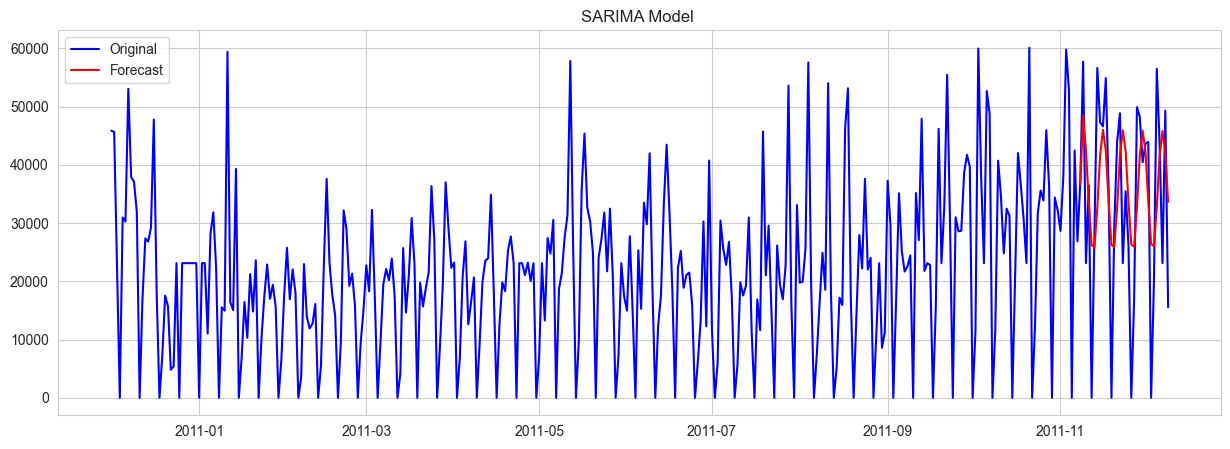

In [49]:
plt.figure(figsize=(15, 5))

plt.plot(df_daily, color='b', label='Original')
plt.plot(forecast, color='r', label='Forecast')

plt.legend()
plt.title('SARIMA Model ')
plt.show()

In [50]:
# residuals = test - predictions
residuals = [test.values[i] - forecast.values[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals, columns=['Residuals'])
residuals.describe()

,Residuals
count,32.00
mean,"-2,289.44"
std,"14,700.40"
min,"-26,378.13"
25%,"-11,286.00"
50%,"1,635.67"
75%,"7,108.41"
max,"23,933.80"


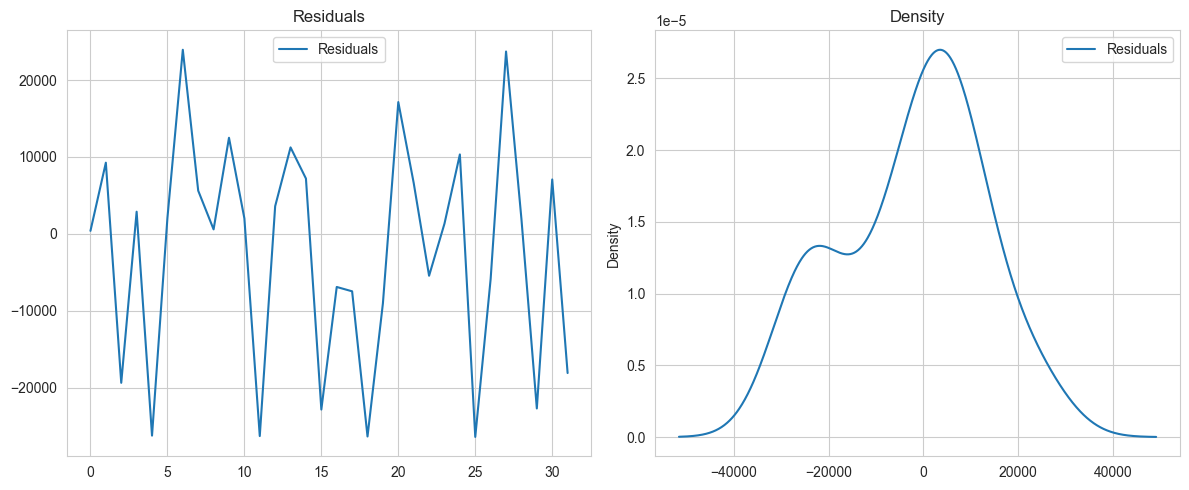

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

residuals = pd.DataFrame(residuals)
residuals.plot(title='Residuals', ax=ax[0],)
residuals.plot(kind='kde', title='Density', ax=ax[1], )

plt.tight_layout()
plt.show()

In [52]:
# Evaluate the model performance
rmse = np.sqrt(mean_squared_error(test, forecast['Forecast'].dropna())).round(3)

mape = np.round(np.mean(np.abs(test['Sales'] - 
                               forecast['Forecast'].dropna()) / 
                               test['Sales']) * 100, 3)

print(rmse)
print(mape)

14648.898
inf


#### 5. ARIMA Model

#### 5.1 Given Order 

In [35]:
from statsmodels.tsa.arima.model import ARIMA 

In [53]:
arima_model = ARIMA(train.fillna(0),order=(1, 1, 1))
arima_fit = arima_model.fit()

print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  342
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3728.097
Date:                Tue, 17 Dec 2024   AIC                           7462.194
Time:                        00:50:16   BIC                           7473.690
Sample:                    12-01-2010   HQIC                          7466.774
                         - 11-07-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1615      0.085      1.907      0.057      -0.004       0.327
ma.L1         -0.9680      0.021    -47.001      0.000      -1.008      -0.928
sigma2      2.344e+08   2.95e-11   7.94e+18      0.0

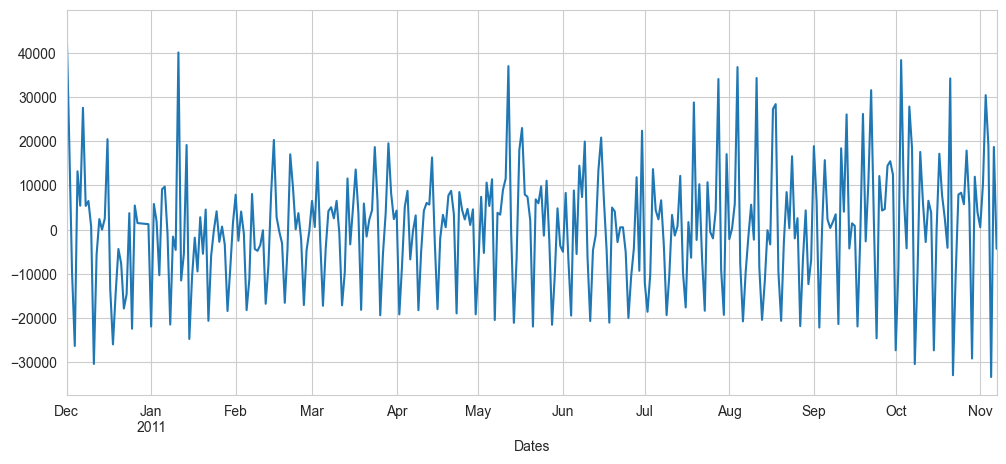

In [54]:
plt.rcParams['figure.figsize'] = 12, 5

arima_residuals = arima_fit.resid
arima_residuals.plot()
plt.show()

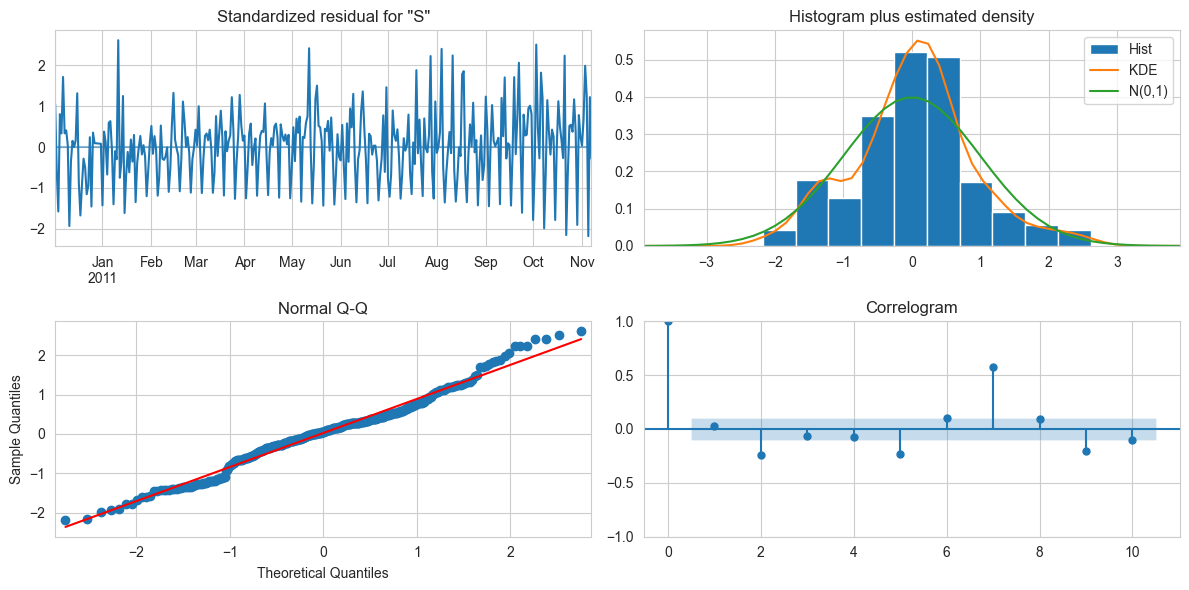

In [55]:
arima_fit.plot_diagnostics(figsize=(12, 6))
plt.tight_layout();

##### 5.2 Making predictions

In [56]:
# Make predictions using forecast(steps=n)
# y_pred = arima_fit.forecast()[0]
forecast = arima_fit.forecast(steps=len(test))

# Combine the test and forecast for comparison
arima_results = pd.DataFrame({'Actual': test['Sales'], 
                              'Forecast': forecast.values}, 
                              index=test.index)

# Display the results
arima_results.head()

,Actual,Forecast
Dates,,
2011-11-08,"37,132.50","28,563.54"
2011-11-09,"57,713.44","28,834.49"
2011-11-10,"23,120.55","28,878.23"
2011-11-11,"36,510.41","28,885.29"
2011-11-12,0.00,"28,886.43"


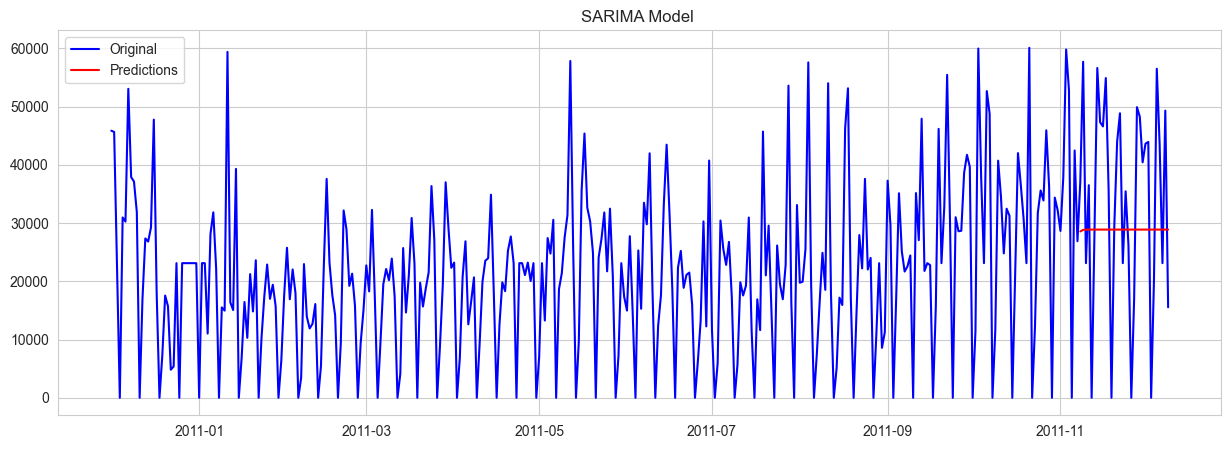

In [57]:
plt.rcParams['figure.figsize'] = 15, 5

plt.plot(df_daily['Sales'], color='b', label='Original')
plt.plot(arima_results['Forecast'], color='r', label='Predictions')

plt.legend()
plt.title('SARIMA Model ')
plt.show()

In [58]:
# Make predictions using predict(start, end)
predictions = arima_fit.predict(start=343, end=373)[0]

predictions = pd.DataFrame({'Actual': test['Sales'], 
                            'Predictions': predictions}, 
                            index=test.index)
predictions.head()

,Actual,Predictions
Dates,,
2011-11-08,"37,132.50","28,834.49"
2011-11-09,"57,713.44","28,834.49"
2011-11-10,"23,120.55","28,834.49"
2011-11-11,"36,510.41","28,834.49"
2011-11-12,0.00,"28,834.49"


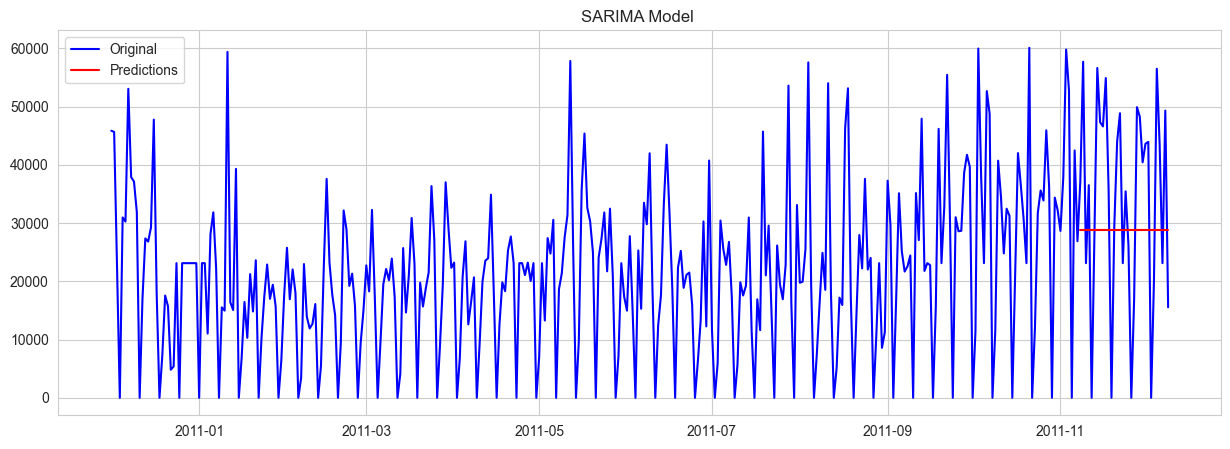

In [59]:
plt.rcParams['figure.figsize'] = 15, 5

plt.plot(df_daily['Sales'], color='b', label='Original')
plt.plot(predictions['Predictions'], color='r', label='Predictions')

plt.legend()
plt.title('SARIMA Model ')
plt.show()

In [60]:
train

,Sales
Dates,
2010-12-01,"45,867.26"
2010-12-02,"45,656.47"
2010-12-03,"22,553.38"
2010-12-04,0.00
2010-12-05,"30,970.28"
...,...
2011-11-03,"59,808.85"
2011-11-04,"52,823.82"
2011-11-05,0.00


In [61]:
history = [x for x in train.values]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    arima_model = ARIMA(history, order=(1, 1, 1))
    arima_fit = arima_model.fit()
    # yhat = arima_fit.forecast()[0]
    yhat = arima_fit.forecast(steps=len(test))[0]
    
    predictions.append(yhat)

    obs = test.iloc[t]
    history.append(obs)
    print('predicted: %.2f, expected: %.2f' % (yhat, obs))



predicted: 28563.54, expected: 37132.50
predicted: 30486.39, expected: 57713.44
predicted: 34984.47, expected: 23120.55
predicted: 28994.49, expected: 36510.41
predicted: 31426.84, expected: 0.00
predicted: 24346.91, expected: 27879.51
predicted: 28897.20, expected: 56642.54
predicted: 34339.58, expected: 47322.45
predicted: 33474.13, expected: 46604.65
predicted: 34038.85, expected: 54910.08
predicted: 36391.33, expected: 35644.04
predicted: 33255.97, expected: 0.00
predicted: 25905.54, expected: 29485.83
predicted: 30871.79, expected: 43986.79
predicted: 33739.38, expected: 48864.09
predicted: 35195.28, expected: 23120.55
predicted: 30541.82, expected: 35461.34
predicted: 32715.22, expected: 26162.32
predicted: 30966.31, expected: 0.00
predicted: 25424.80, expected: 16929.67
predicted: 27811.41, expected: 49909.04
predicted: 34048.38, expected: 48263.84
predicted: 34362.53, expected: 40436.41
predicted: 33303.23, expected: 43634.37
predicted: 34251.05, expected: 43948.09
predicted: 3

In [62]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 17828.283


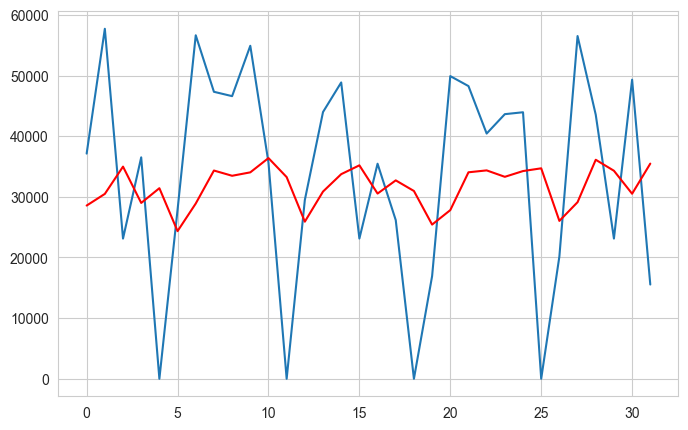

In [63]:
# plot forecasts against actual outcomes
plt.figure(figsize=(8, 5))

plt.plot(test.values)
plt.plot(predictions, color='red')

plt.show()

In [64]:
# Combine the test and predictions for comparison
results = pd.DataFrame({'Actual': test['Sales'], 
                        'Forecast': predictions}, index=test.index)

results.head()

,Actual,Forecast
Dates,,
2011-11-08,"37,132.50","28,563.54"
2011-11-09,"57,713.44","30,486.39"
2011-11-10,"23,120.55","34,984.47"
2011-11-11,"36,510.41","28,994.49"
2011-11-12,0.00,"31,426.84"


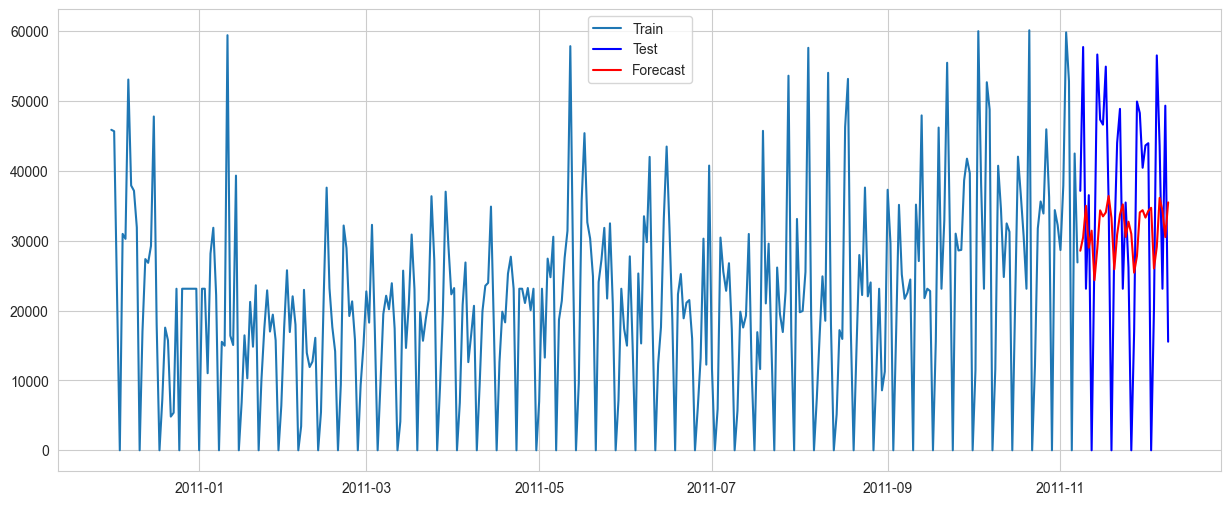

In [65]:
# plot the results
plt.figure(figsize=(15, 6))

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='blue')
plt.plot(results.index, results['Forecast'], label='Forecast', color='red')

plt.legend()
plt.show()

##### 5.3 Model Evaluation

In [66]:
# report performance
mse = mean_squared_error(test, predictions)
print(f'MSE: {mse:,.2f}')

mae = mean_absolute_error(test, predictions)
print(f'MAE: {mae:,.2f}')

rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse:,.2f}')

MSE: 317,847,683.56
MAE: 15,044.36
RMSE: 17,828.28


##### 5.4 Finetuning the parameters

In [67]:
# Manual grid search for ARIMA parameters
best_mse = float("inf")
best_order = (0, 0, 0)

# Define parameter ranges
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

# Grid search
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit ARIMA model
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()

                # Rolling forecast
                history = [x for x in train.values]
                predictions = []
                for t in range(len(test)):
                    y_pred = model_fit.forecast()[0]
                    predictions.append(y_pred)
                    obs = test.iloc[t]
                    history.append(obs)
                    model = ARIMA(history, order=(p, d, q))
                    model_fit = model.fit()

                mse = mean_squared_error(test, predictions)
                if mse < best_mse:
                    best_mse = mse
                    best_order = (p, d, q)
            except:
                continue

print(f'Best ARIMA order: {best_order} with MSE: {best_mse}')


Best ARIMA order: (2, 1, 2) with MSE: 272473772.48215395


In [68]:
# Fit best ARIMA model
best_model = ARIMA(train, order=best_order)
best_model_fit = best_model.fit()

# Rolling forecast with best model
history = [x for x in train.values]
predictions = []
for t in range(len(test)):
    y_pred = best_model_fit.forecast()[0]
    predictions.append(y_pred)
    obs = test.iloc[t]
    history.append(obs)
    best_model = ARIMA(history, order=best_order)
    best_model_fit = best_model.fit()

# Combine the test and predictions for comparison
results = pd.DataFrame({'Actual': test['Sales'], 'Forecast': predictions}, 
                       index=test.index)

results.head()

,Actual,Forecast
Dates,,
2011-11-08,"37,132.50","31,861.13"
2011-11-09,"57,713.44","36,121.72"
2011-11-10,"23,120.55","39,819.31"
2011-11-11,"36,510.41","26,857.23"
2011-11-12,0.00,"35,928.67"


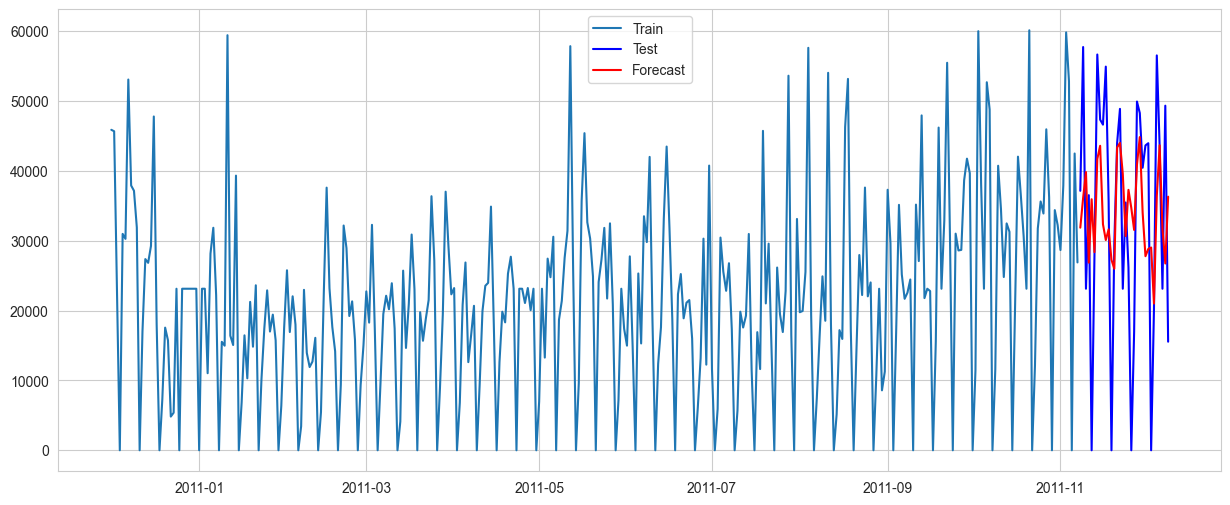

In [69]:
# Optionally, plot the results
plt.figure(figsize=(15, 6))

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='blue')
plt.plot(results.index, results['Forecast'], label='Forecast', color='red')

plt.legend()
plt.show()

In [70]:
# report performance
mse = mean_squared_error(test, predictions)
print(f'MSE: {mse:,.2f}')

mae = mean_absolute_error(test, predictions)
print(f'MAE: {mae:,.2f}')

rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse:,.2f}')

MSE: 272,473,772.48
MAE: 13,161.45
RMSE: 16,506.78


#### 6. SARIMA Model

Best model:  ARIMA(1,0,0)(0,1,1)[7]

##### 6.1 For Given order & Seasonal Order

In [71]:
sarima_model = SARIMAX(train.fillna(0), 
                       order=(1, 0, 0), 
                       seasonal_order=(0, 1, 1, 7))

# Fit the model
sarima_fit = sarima_model.fit()

# Print model summary
print(sarima_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                  342
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -3544.063
Date:                             Tue, 17 Dec 2024   AIC                           7094.125
Time:                                     00:52:42   BIC                           7105.568
Sample:                                 12-01-2010   HQIC                          7098.687
                                      - 11-07-2011                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1007      0.081      1.247      0.212      -0.058       0.259
ma.S.L7       -0.7820      

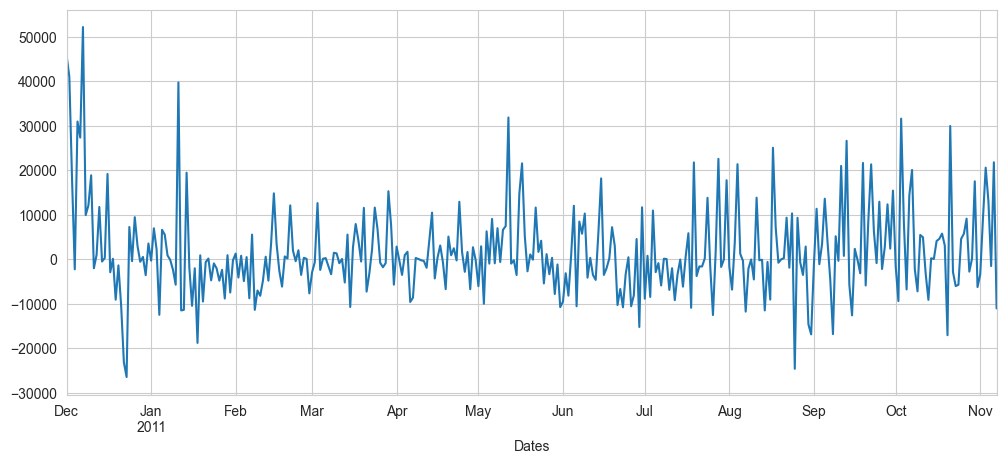

In [72]:
plt.rcParams['figure.figsize'] = 12, 5

residuals = sarima_fit.resid
residuals.plot()
plt.show()

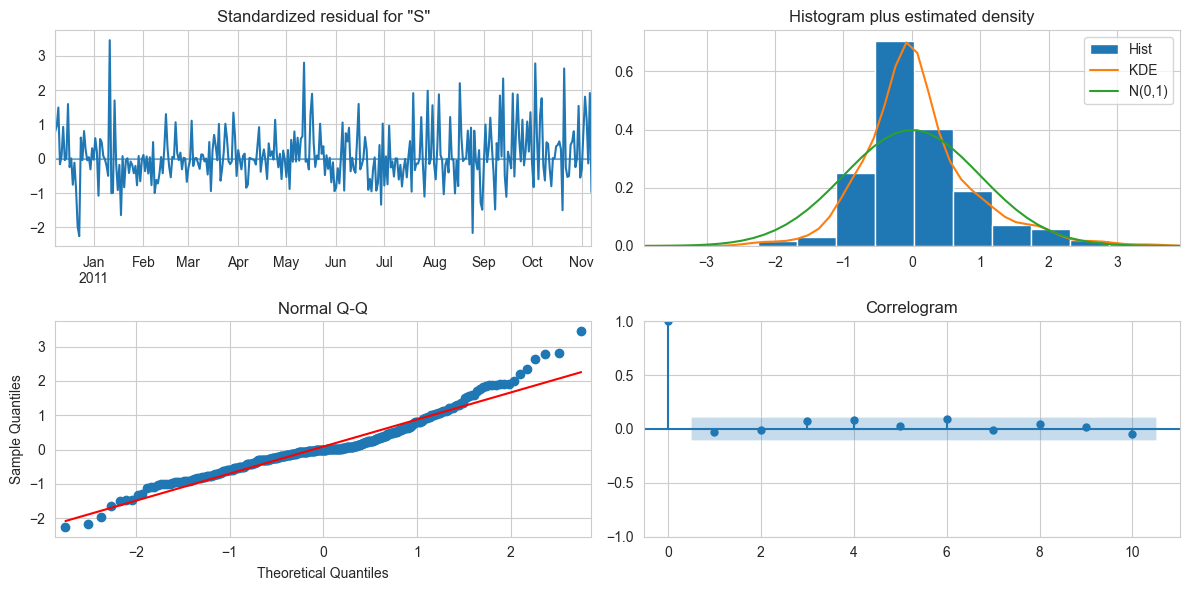

In [175]:
sarima_fit.plot_diagnostics(figsize=(12, 6))
plt.tight_layout();

##### 6.2 Making predictions

In [73]:
sarima_forecast = sarima_fit.forecast(steps=len(test))

sarima_results = pd.DataFrame({'Actual': test['Sales'], 
                               'Forecast': sarima_forecast},
                               index=test.index)
sarima_results.head()

,Actual,Forecast
Dates,,
2011-11-08,"37,132.50","30,777.17"
2011-11-09,"57,713.44","30,916.84"
2011-11-10,"23,120.55","42,987.64"
2011-11-11,"36,510.41","40,914.17"
2011-11-12,0.00,-0.09


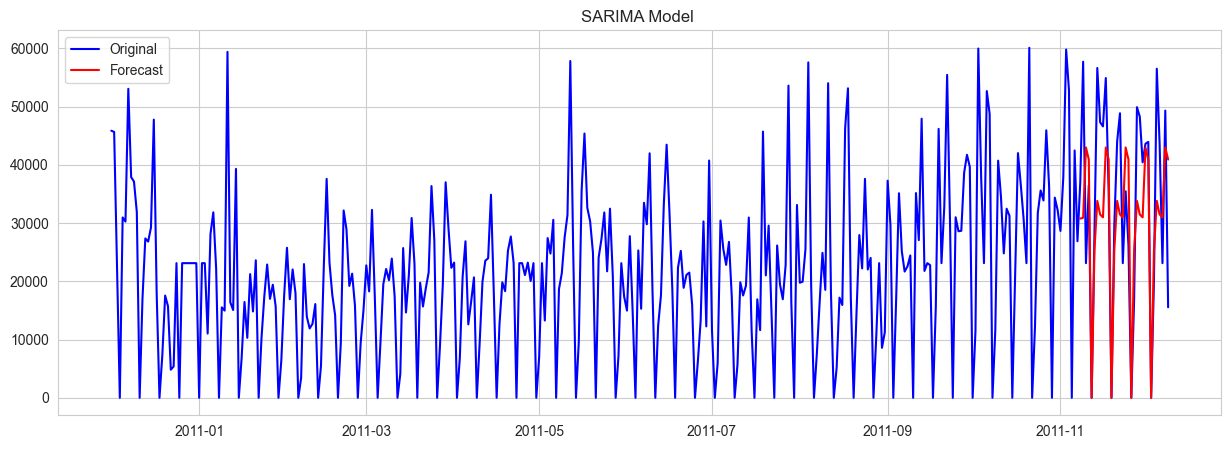

In [74]:
plt.rcParams['figure.figsize'] = 15, 5

plt.plot(df_daily['Sales'], color='b', label='Original')
plt.plot(sarima_results['Forecast'], color='r', label='Forecast')

plt.legend()
plt.title('SARIMA Model ')
plt.show()

In [75]:
prediction = sarima_fit.predict(start=342, end=373)

sarima_results = pd.DataFrame({'Actual': test['Sales'], 
                               'Prediction': prediction},
                               index=test.index)
sarima_results.head()

,Actual,Prediction
Dates,,
2011-11-08,"37,132.50","30,777.17"
2011-11-09,"57,713.44","30,916.84"
2011-11-10,"23,120.55","42,987.64"
2011-11-11,"36,510.41","40,914.17"
2011-11-12,0.00,-0.09


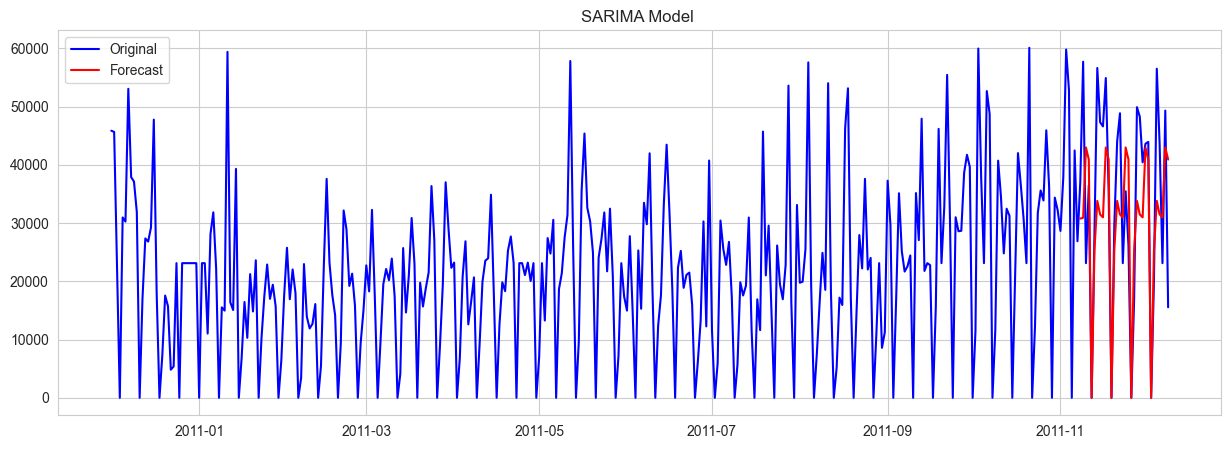

In [76]:
plt.rcParams['figure.figsize'] = 15, 5

plt.plot(df_daily['Sales'], color='b', label='Original')
plt.plot(sarima_results['Prediction'], color='r', label='Forecast')

plt.legend()
plt.title('SARIMA Model ')
plt.show()

##### 6.3 Finetuning the parameters



In [77]:
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
seasonal_period = 7  # Adjust according to your seasonal period

best_mse = float("inf")
best_order = (0, 0, 0, 0)

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        try:
                            # Fit SARIMA model
                            model = SARIMAX(train, order=(p, d, q), 
                                            seasonal_order=(P, D, Q, seasonal_period))
                            model_fit = model.fit(disp=False)

                            # Rolling forecast
                            history = train.values.tolist()
                            predictions = []
                            for t in range(len(test)):
                                y_pred = model_fit.forecast(steps=1)[0]
                                predictions.append(y_pred)
                                obs = test.iloc[t]
                                history.append(obs)
                                model = SARIMAX(history, order=(p, d, q), 
                                                seasonal_order=(P, D, Q, seasonal_period))
                                model_fit = model.fit(disp=False)

                            mse = mean_squared_error(test, predictions)
                            if mse < best_mse:
                                best_mse = mse
                                best_order = (p, d, q, P, D, Q)
                        except:
                            continue

print(f'Best SARIMA order: {best_order} with MSE: {best_mse}')

Best SARIMA order: (0, 1, 2, 1, 0, 1) with MSE: 133698327.12472121


In [78]:
# Fit best SARIMA model
best_sarima_model = SARIMAX(train, order=(best_order[0], best_order[1], best_order[2]), 
                            seasonal_order=(best_order[3], best_order[4], best_order[5], 
                                            seasonal_period))
best_sarima_fit = best_sarima_model.fit(disp=False)

# Rolling forecast with best model
history = train.values.tolist()
predictions = []
for t in range(len(test)):
    y_pred = best_sarima_fit.forecast(steps=1)[0]
    predictions.append(y_pred)
    obs = test.iloc[t]
    history.append(obs)
    best_sarima_model = SARIMAX(history, order=(best_order[0], best_order[1], best_order[2]), 
                                 seasonal_order=(best_order[3], best_order[4], best_order[5], 
                                                 seasonal_period))
    best_sarima_fit = best_sarima_model.fit(disp=False)

# Combine the test and predictions for comparison
results = pd.DataFrame({'Actual': test['Sales'], 'Forecast': predictions}, index=test.index)
results.head()

,Actual,Forecast
Dates,,
2011-11-08,"37,132.50","36,810.06"
2011-11-09,"57,713.44","36,030.57"
2011-11-10,"23,120.55","48,050.37"
2011-11-11,"36,510.41","37,501.96"
2011-11-12,0.00,"2,037.14"


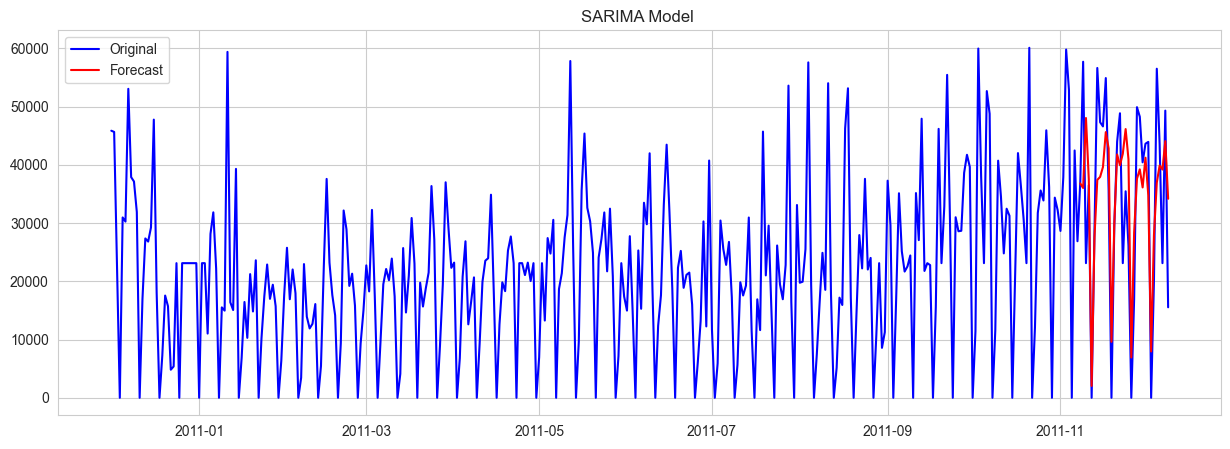

In [79]:
plt.rcParams['figure.figsize'] = 15, 5

plt.plot(df_daily['Sales'], color='b', label='Original')
plt.plot(results['Forecast'], color='r', label='Forecast')

plt.legend()
plt.title('SARIMA Model ')
plt.show()

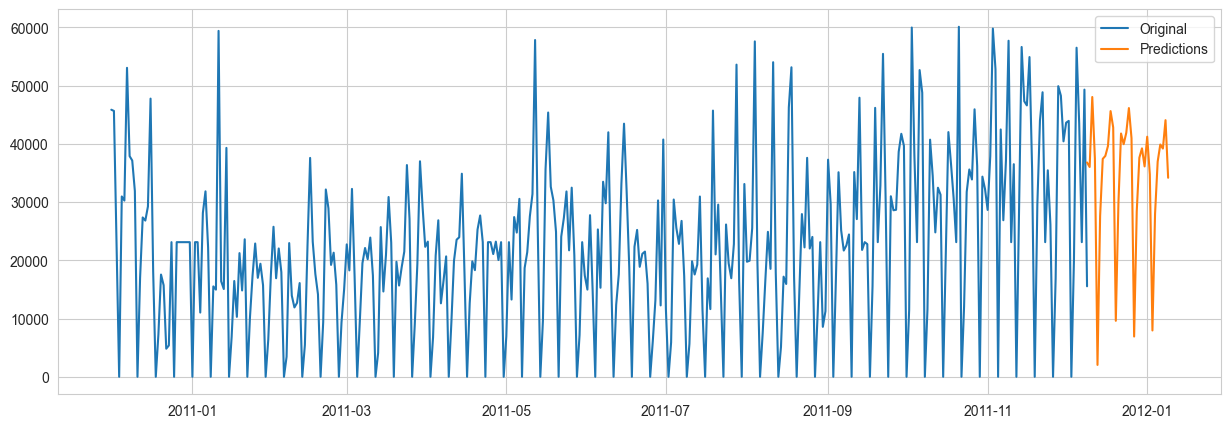

In [80]:
### Make futre predictions
pred_series = pd.Series(predictions, index=None)

# Create a date range
pred_series.index = pd.date_range(df_daily.index[-1], periods=32, 
                                  freq='D', tz=None)
# pred_series

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(df_daily.Sales, label='Original')
ax.plot(pred_series, label='Predictions')

plt.legend()
plt.show()